# Try with DeepWalk Algorithm

In [18]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 33.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.7 MB/s eta 0:00:00


In [19]:
import numpy as np
import networkx as nx
import threading
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

Create a customed Graph

In [20]:
class Graph:
    def __init__(self, graph_dict = None, directed = False):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        self.lock = threading.Lock()

        if not directed:
            self.make_undirected()

    def get_vertices(self):
        return list(self.graph_dict.keys())

    def make_adjacency_matrix(self):
        vertices = list(self.graph_dict.keys())
        shape_matrix = len(vertices)
        adj_matrix = np.zeros((shape_matrix, shape_matrix))

        for i in range(shape_matrix):
            for j in range(shape_matrix):
                if vertices[j] in self.graph_dict[vertices[i]]:
                    adj_matrix[i][j] = 1

        return adj_matrix


    def add_vertices(self, vertex):
        if vertex not in self.graph_dict:
            self.graph_dict[vertex] = []

    def add_edges(self, vertex1, vertex2):
        self.add_vertices(vertex1)
        self.add_vertices(vertex2)
        self.graph_dict[vertex1].append(vertex2)

        if not self.directed:
            self.graph_dict[vertex2].append(vertex1)

    def make_undirected(self):
        for vertex in self.graph_dict:
            for neighbor in self.graph_dict[vertex]:
                if vertex not in self.graph_dict[neighbor]:
                    self.graph_dict[neighbor].append(vertex)

    def to_networkx(self):
        if self.directed:
            G_nx = nx.DiGraph()
        else:
            G_nx = nx.Graph()

        for vertex, neighbors in self.graph_dict.items():
            G_nx.add_node(vertex)
            for neighbor in neighbors:
                G_nx.add_edge(vertex, neighbor)

        return G_nx

    def __str__(self):
        return str(self.graph_dict)



In [81]:
# G = Graph()
# G.add_vertices('A')
# G.add_vertices('B')
# G.add_vertices('C')
# G.add_vertices('D')
# G.add_vertices('E')
# G.add_vertices('F')
# G.add_vertices('G')
# G.add_vertices('H')
# G.add_edges('A', 'B')
# G.add_edges('A', 'C')
# G.add_edges('B', 'D')
# G.add_edges('C', 'E')
# G.add_edges('D', 'E')
# G.add_edges('D', 'F')
# G.add_edges('E', 'F')
# G.add_edges('E', 'G')
# G.add_edges('F', 'H')
# G.add_edges('G', 'H')
# G.add_edges('H', 'A')
# G.add_edges('H', 'B')
# G.add_edges('H', 'C')


# print(G.graph_dict)

# Create the graph
G = Graph()

# Add 16 vertices
for vertex in 'ABCDEFGHIJKLMNOP':
    G.add_vertices(vertex)

# Add edges between vertices
edges = [
    ('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'E'), 
    ('C', 'F'), ('C', 'G'), ('D', 'H'), ('E', 'I'), 
    ('F', 'J'), ('G', 'K'), ('H', 'L'), ('I', 'M'), 
    ('J', 'N'), ('K', 'O'), ('L', 'P'), ('M', 'N'), 
    ('N', 'O'), ('O', 'P'), ('P', 'A'), ('A', 'D'),
    ('E', 'H'), ('F', 'I'), ('G', 'J'), ('H', 'K')
]

for edge in edges:
    G.add_edges(*edge)

# Print the graph dictionary
print(G.graph_dict)

{'A': ['B', 'C', 'P', 'D'], 'B': ['A', 'D', 'E'], 'C': ['A', 'F', 'G'], 'D': ['B', 'H', 'A'], 'E': ['B', 'I', 'H'], 'F': ['C', 'J', 'I'], 'G': ['C', 'K', 'J'], 'H': ['D', 'L', 'E', 'K'], 'I': ['E', 'M', 'F'], 'J': ['F', 'N', 'G'], 'K': ['G', 'O', 'H'], 'L': ['H', 'P'], 'M': ['I', 'N'], 'N': ['J', 'M', 'O'], 'O': ['K', 'N', 'P'], 'P': ['L', 'O', 'A']}


In [82]:
adj_matrix = G.make_adjacency_matrix()
print(adj_matrix)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]


In [83]:
g_nx = G.to_networkx()
print(g_nx.nodes)
print(g_nx.edges)

['A', 'B', 'C', 'P', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
[('A', 'B'), ('A', 'C'), ('A', 'P'), ('A', 'D'), ('B', 'D'), ('B', 'E'), ('C', 'F'), ('C', 'G'), ('P', 'L'), ('P', 'O'), ('D', 'H'), ('E', 'I'), ('E', 'H'), ('F', 'J'), ('F', 'I'), ('G', 'K'), ('G', 'J'), ('H', 'L'), ('H', 'K'), ('I', 'M'), ('J', 'N'), ('K', 'O'), ('M', 'N'), ('N', 'O')]


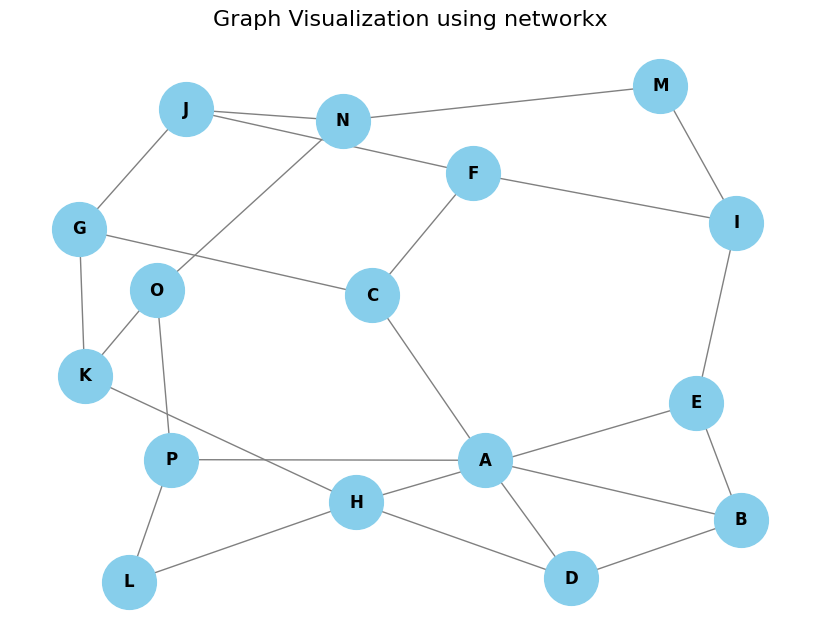

In [84]:
# Visualize the graph using networkx
plt.figure(figsize=(8, 6))
nx.draw(g_nx, with_labels=True, node_color='skyblue',
        node_size=1500, edge_color='gray', font_size=12, font_weight='bold')
plt.title("Graph Visualization using networkx", fontsize=16)
plt.show()

## Random Walk Algorithm

The random walk in DeepWalk generates sequences of nodes (analogous to sentences in NLP). These sequences capture the graph's local and global structure, which are then used for training a Skip-gram model to generate embeddings. The sequences of nodes are chosen randomly from the neighbor 
of the current node and repeat until reaches the specified length 

### Steps in Random Walk for DeepWalk

1. **Graph Initialization**  
   Input is an undirected graph $(G = (V, E))$, where $V$ represents nodes, and $E$ represents edges.

2. **Random Walk Parameters**  
   - **Walk length  $l$**: The number of steps in each random walk.
   - **Number of walks per node $k$**: How many walks to start from each node.
   - **Transition probabilities**: Uniform for a basic random walk, meaning all neighbors have an equal chance of being chosen.

3. **Generate Random Walks**  
   For each node $v_i \in V$:
   - Start a random walk at $v_i$.
   - At each step, choose $v_k$ to a randomly chosen neighbor of the current node, for which $k \in \mathcal{N}(v_i)$ and the set $\mathcal{N}(v_i)$ is the neighborhood of the vertex $v_i$.
   - Continue until the walk reaches the specified length $l$.
   
   This generates a corpus of random walks (node sequences).

4. **Train Skip-gram Model**  
   Treat the random walks as a "text corpus" and train a Skip-gram model (e.g., from Word2Vec) to learn node embeddings.

---

In [85]:
# The algorithm of the Random Algorithm 
def random_walk(graph, start_vertex, num_steps):
    """
    Performs a random walk on a graph starting from a specified vertex.

    Parameters
    ----------
    graph: Graph object
        The graph containing nodes (vertices) and edges.
    start_vertex: Any
        The starting node for the random walk.
    num_steps: int
        The number of steps the random walk should take.

    Returns
    -------
    traverse_path: list
        A list of nodes visited during the random walk.

    Raises
    ------
    ValueError
        If the start_vertex is not a valid node in the graph.
    """
    if start_vertex not in graph.graph_dict:
        return ValueError("Start vertex not in graph")

    current_vertex = start_vertex
    traverse_path = [current_vertex]

    for _ in range(num_steps):
        neighbors = graph.graph_dict[current_vertex]

        if not neighbors:
            break

        next_step = np.random.choice(neighbors)    
        traverse_path.append(next_step)
        current_vertex = next_step

    return traverse_path


# Conducting the algorithm with multi-threading to improve the performance of the model
def random_walk_multi(graph, start_vertices, num_steps, num_threads = 4):
    results = {}

    def worker(start_vertex):
        path = random_walk(graph, start_vertex, num_steps)
        with graph.lock:
            results[start_vertex] = path

    with ThreadPoolExecutor(max_workers = num_threads) as executor:
        executor.map(worker, start_vertices)

    return results


start_vertices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
num_steps = 4
num_threads = 4

result_paths = random_walk_multi(G, start_vertices, num_steps, num_threads)
print(result_paths)

{'A': ['A', np.str_('P'), np.str_('L'), np.str_('H'), np.str_('E')], 'B': ['B', np.str_('E'), np.str_('H'), np.str_('K'), np.str_('O')], 'C': ['C', np.str_('A'), np.str_('D'), np.str_('B'), np.str_('A')], 'D': ['D', np.str_('A'), np.str_('B'), np.str_('D'), np.str_('B')], 'E': ['E', np.str_('I'), np.str_('M'), np.str_('N'), np.str_('O')], 'F': ['F', np.str_('C'), np.str_('F'), np.str_('I'), np.str_('F')], 'G': ['G', np.str_('C'), np.str_('G'), np.str_('C'), np.str_('A')], 'H': ['H', np.str_('E'), np.str_('H'), np.str_('E'), np.str_('B')]}


## Implementing the DeepWalk algorithm

These random walks sequences can be thought as the basic phrases or sentences of the graph. We can take the direct analogy to the concept of Word2Vec, which estimate the likelihood of observing the vertex $v_i$ given the the neighboring vertex $v_k$. However, the goal is to learn the latent representation $\Phi \in \mathbb{R}^{|V| \times d}$. The mapping $\Phi : v_i \in \mathbb{R} \rightarrow \mathbb{R}^{d}$ is the social representation of the vertex $v_i$.

The problem then to estimate the likelihood:

$$Pr(v_i | (\Phi(v_1), \Phi(v_2). \dots, \Phi(v_{i - 1}))$$

However, as the length of walk increases, computing the equation above is unfeasible. Hence, we have:
- Use 1 word to predict the context
- The context are the words in the left or in the right of the targeted word
- Removes the ordering constraint

Which is equivalent to the optimization problem below 
$$\underset{\Phi}{\text{minimize}} \quad - \log \Pr\left(\{v_{i-w}, \cdots, v_{i-1}, v_{i+1}, \cdots, v_{i+w}\} \mid \Phi(v_i)\right)$$

Solving this optimization captures the shared similarities in the local graph structure between vertices. It can be viewed as the sum of probabilities $P(v_k | v_i)$, which helps accelerate training. This process is known as the Skip-Gram Algorithm, a key component of the Word2Vec algorithm used in Natural Language Processing (NLP)

### Skip-Gram Algorithm

Once random walks are generated, DeepWalk applies the Skip-gram model to these sequences. In the context of DeepWalk, the Skip-gram model learns to predict the context nodes (neighbors) of a target node within a fixed-size window, based on the random walk sequences.

Given a random walk sequence:

$v_i, v_j, v_k, v_l, \dots$

For each node $v_i$ in the sequence, the Skip-gram model will learn to predict the neighboring nodes $v_i, v_j, v_k, v_l, \dots$ as its context within a fixed-size window.

Mathematically, the Skip-gram model tries to maximize the likelihood of observing the context nodes given the target node, which is the same objective as in the Word2Vec Skip-gram model:

$$P(v_j | v_i) = \frac{\exp(\Phi(v_i)^T \cdot \Phi(v_j))}{\sum_{v_k \in V} \exp(\Phi(v_i)^T \cdot \Phi(v_k))}$$




Where:

- $\Phi(v_i)$ is the vector embedding of node $v_i$
- $\Phi(v_j)$ is the vector embedding of the context node $v_j$
- $V$ is the set of all nodes in the graph.

In [86]:
def skipgram_algorithm(all_walks, window_size):

    training_data = []
    for walk in all_walks:
        for i in range(len(walk)):
            center_vertex = walk[i]

            left_start = max(0, i - window_size)
            right_end = min(len(walk), i + window_size + 1)
            for j in range(left_start, right_end):
                if i != j:
                    training_data.append((center_vertex, walk[j]))
    return training_data


In [87]:
class DeepWalk(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(DeepWalk, self).__init__()
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        # self.output_layer = nn.Linear(embedding_dim, num_nodes, bias = False)

    def forward(self, center, context):
        # return self.output_layer(self.embeddings(input_walks))

        center_embed = self.embeddings(center)
        context_embed = self.embeddings(context)

        # Applying log-sum-exp trick to solve the overflow problem
        result = torch.matmul(center_embed, context_embed.T) # (B, 1)
        all_logits = torch.matmul(center_embed, self.embeddings.weight.T) # (B, Vocab_size)

        max_logits, _ = torch.max(all_logits, dim = 1, keepdim = True)
        log_sum_exp = max_logits + torch.log(torch.sum(torch.exp(all_logits - max_logits), dim=1, keepdim=True))

        log_prob = result - log_sum_exp

        return log_prob

### Hierarchical Softmax

In [143]:
# def length_binary_tree(node):
#     count = 0
#     print(node)
#     while (node > 1):
#         node //= 2
#         count += 1
#     return count

def length_binary_tree_tensors(nodes):
    count = torch.zeros_like(nodes)
    while torch.any(nodes > 1):
        nodes = nodes // 2
        count += (nodes > 0).int()

    return count

# Example tensor input
nodes = torch.tensor(
    [23, 30, 24, 16, 28, 31, 31, 16, 31, 31, 30, 24, 25, 28, 27, 21, 
     29, 20, 26, 23, 30, 27, 29, 30, 17, 20, 30, 27, 22, 16, 17, 20], 
    device='cuda:0'
)

# Calculate lengths for each node
lengths = length_binary_tree_tensors(nodes)
print(lengths)

# length_binary_tree(6)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


In [161]:
def path_binary_tree_tensors(nodes):
    max_steps = torch.floor(torch.log2(nodes.float())).int() + 1  # Maximum path length for each node
    batch_size = len(nodes)
    
    paths = torch.zeros((batch_size, max_steps.max()), device=nodes.device, dtype=torch.int)
    
    for i in range(max_steps.max()):
        paths[:, i] = nodes
        nodes = nodes // 2  # Update nodes by dividing by 2
        nodes[nodes < 1] = 0  # Stop updating for nodes <= 1
    
    # Remove trailing zeros for each row
    path_lengths = max_steps
    # print(paths)
    trimmed_paths = torch.tensor([paths[i, :path_lengths[i]].tolist() for i in range(batch_size)])
    return trimmed_paths


nodes = torch.tensor([23, 30, 24, 16, 28], device='cuda:0')
paths = path_binary_tree_tensors(nodes)
print(paths)
for i, path in enumerate(paths):
    print(f"Path for node {i+1}: {path}")

tensor([[23, 11,  5,  2,  1],
        [30, 15,  7,  3,  1],
        [24, 12,  6,  3,  1],
        [16,  8,  4,  2,  1],
        [28, 14,  7,  3,  1]])
Path for node 1: tensor([23, 11,  5,  2,  1])
Path for node 2: tensor([30, 15,  7,  3,  1])
Path for node 3: tensor([24, 12,  6,  3,  1])
Path for node 4: tensor([16,  8,  4,  2,  1])
Path for node 5: tensor([28, 14,  7,  3,  1])


In [234]:
class DeepWalk_HierSoftmax(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(DeepWalk_HierSoftmax, self).__init__()
        self.num_nodes = num_nodes
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.probs_tensor = nn.Parameter(torch.rand(2 * num_nodes, embedding_dim), 
                                         requires_grad = True)

    def length_binary_tree_tensors(self, nodes):
        count = torch.zeros_like(nodes)
        while torch.any(nodes > 1):
            nodes = nodes // 2
            count += (nodes > 0).int()
    
        return count

    def path_binary_tree_tensors(self, nodes):
        max_steps = torch.floor(torch.log2(nodes.float())).int() + 1  # Maximum path length for each node
        batch_size = len(nodes)
        
        paths = torch.zeros((batch_size, max_steps.max()), device=nodes.device, dtype=torch.int)
        
        for i in range(max_steps.max()):
            paths[:, i] = nodes
            nodes = nodes // 2  # Update nodes by dividing by 2
            nodes[nodes < 1] = 0  # Stop updating for nodes <= 1
        
        # Remove trailing zeros for each row
        path_lengths = max_steps
        # print(paths)
        trimmed_paths = torch.tensor([paths[i, :path_lengths[i]].tolist() for i in range(batch_size)])
        
        return trimmed_paths


    def forward(self, center, context):
        embed_center = self.embeddings(center)
        # print(f'shape of embed_center : {embed_center.shape}')
        context_node = self.num_nodes + context
        
        length_binary = self.length_binary_tree_tensors(context_node)
        path_bin_tree = self.path_binary_tree_tensors(context_node)

        # Prepare paths as a padded tensor
        max_path_len = length_binary.max()
    
        # print(max_path_len)
        logp = torch.zeros((len(context_node), 1), device=context_node.device)
        for i in range(1, max_path_len):
            # Extract the current level's nodes
            nodes = path_bin_tree[:, i]
    
            # Compute signs based on node parity
            signs = torch.where(nodes % 2 == 0, 1.0, -1.0).unsqueeze(1).to(context_node.device)

            # print(torch.matmul(self.probs_tensor[nodes], embed_center.T).shape)

            dot_product = torch.sum(self.probs_tensor[nodes] * embed_center, dim = 1, keepdim = True)

            probs = torch.sigmoid(signs * dot_product)
            
            # probs = torch.sigmoid(signs * torch.matmul(self.probs_tensor[nodes], embed_center.T))
            # print(probs)
            log_probs = torch.log(probs)
            logp += log_probs  # Aggregate probabilities for the batch
            
        return -logp


In [237]:
total_loss = neg_logp.mean()
total_loss

tensor(8.2575, device='cuda:0', grad_fn=<MeanBackward0>)

In [230]:
class DeepWalkDataset(Dataset):
    def __init__(self, training_data, vertex_to_index):
        self.training_data = training_data
        self.vertex_to_index = vertex_to_index

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, index):
        center_vertex, context_vertices = self.training_data[index]
        center_index = torch.tensor(self.vertex_to_index[center_vertex])
        context_indices = torch.tensor(self.vertex_to_index[context_vertices])

        return center_index, context_indices

In [231]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [260]:
num_walks = 30
walk_length = 5
window_size = 2
num_epochs = 5

all_walks = []
list_vertices = G.get_vertices()
for _ in range(num_walks):
    walks = random_walk_multi(G, list_vertices, walk_length)
    all_walks.extend(list(walks.values()))

# return all_walks
vertex_to_index = {vertex: index for index, vertex in enumerate(list_vertices)}
vocab_size = len(vertex_to_index)

training_data = skipgram_algorithm(all_walks, window_size)
training_data = DeepWalkDataset(training_data, vertex_to_index)
training_loader = DataLoader(training_data, batch_size = 32, shuffle = True)

deepwalk_hierarchical = DeepWalk_HierSoftmax(vocab_size, 128).to(device)
optimizer = optim.Adam(deepwalk_hierarchical.parameters(), lr = 0.001)

deepwalk_hierarchical.train()
for epoch in range(num_epochs):
    total_loss = 0
    for center, context in training_loader:
        optimizer.zero_grad()
        center = center.to(device)
        context = context.to(device)
        neg_logp = deepwalk_hierarchical(center, context)

        avg_logp = neg_logp.mean()
        avg_logp.backward()
        # for i in range(neg_logp.size(0)):
        #     neg_logp[i].backward(retain_graph=True)  # retain_graph=True allows multiple backward passes

        optimizer.step()
        total_loss += avg_logp

        # print(avg_logp)

    print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(training_loader)}')



Epoch: 1, Loss: 2.467649459838867
Epoch: 2, Loss: 0.19140072166919708
Epoch: 3, Loss: 0.06121661514043808
Epoch: 4, Loss: 0.029992731288075447
Epoch: 5, Loss: 0.018295640125870705


In [261]:
embedding_weight = deepwalk_hierarchical.embeddings.weight

In [265]:
def calculate_cosine_sim(vector_0, vector_1):
    dot_product = torch.sum(vector_0 * vector_1)
    
    magnitude_0 = torch.sqrt(torch.sum(vector_0 ** 2))
    magnitude_1 = torch.sqrt(torch.sum(vector_1 ** 2))
        
    cosine_similarity = dot_product / (magnitude_0 * magnitude_1)

    return cosine_similarity.item()

vector_0 = embedding_weight[2]  # Node B
vector_1 = embedding_weight[3]  # Node D

print(calculate_cosine_sim(vector_0, vector_1))

0.0006420679274015129


We can measure the cosine similarity of the node `A` and node `D` to evaluate the model

## Let's try some dataset

1. BlogCatalog Dataset

In [269]:
!wget --no-check-certificate "https://datasets.syr.edu/uploads/1252092625/BlogCatalog-dataset.zip"

--2024-12-03 16:32:22--  https://datasets.syr.edu/uploads/1252092625/BlogCatalog-dataset.zip
Resolving datasets.syr.edu (datasets.syr.edu)... 128.230.247.57
Connecting to datasets.syr.edu (datasets.syr.edu)|128.230.247.57|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 13430637 (13M) [application/zip]
Saving to: ‘BlogCatalog-dataset.zip’

BlogCatalog-dataset 100%[===================>]  12.81M  44.1MB/s    in 0.3s    

2024-12-03 16:32:22 (44.1 MB/s) - ‘BlogCatalog-dataset.zip’ saved [13430637/13430637]



In [271]:
!unzip BlogCatalog-dataset.zip

Archive:  BlogCatalog-dataset.zip
   creating: BlogCatalog-dataset/
   creating: BlogCatalog-dataset/data/
  inflating: BlogCatalog-dataset/data/edges.csv  
  inflating: BlogCatalog-dataset/data/nodes.csv  
  inflating: BlogCatalog-dataset/readme.txt  


In [272]:
!ls

BlogCatalog-dataset  BlogCatalog-dataset.zip  DeepWalk.ipynb


Loading the dataset

In [285]:
import pandas as pd
from torch.utils.data import Dataset
import networkx as nx

In [294]:
nodes_df = pd.read_csv('BlogCatalog-dataset/data/nodes.csv',
                   header = None, names = ['id'])
edges_df = pd.read_csv('BlogCatalog-dataset/data/edges.csv',
                   header = None, names = ['source', 'target'])

G = nx.Graph()

for _, row in nodes_df.iterrows():
    G.add_node(row['id'])

G.add_edges_from(edges_df.values)



In [295]:
# Number of nodes
print(f"Number of nodes: {len(G.nodes)}")

# Number of edges
print(f"Number of edges: {len(G.edges)}")

# # List of nodes
# print(f"Nodes: {list(G.nodes)}")

# # List of edges
# print(f"Edges: {list(G.edges)}")

Number of nodes: 88784
Number of edges: 4186390
